 # Analyzing Food Insecurity in NYC using Safegraph CBG Data

In this final challenge, we continue our efforts in analyzing food insecurity in NYC. In the previous attemps (HW4), we didn't see a relationship between star ratings for grocery stores compared to food insecurity level in the community district. However, we were only looking at Key Food stores. We would like to extend the study to all grocery stores in NYC. To do that, we have collect store ratings data through [Google Places API](https://developers.google.com/maps/documentation/places/web-service/overview) with respect to supermarket stores. This results in over 7000 locations, but we are only interested in [1200 stores](https://nyu.carto.com/u/huyvo/builder/12ad7126-f9f4-480e-a921-0fab040d209e/) with star ratings. Unfortunately, we also do not see a clear relationshipp in this case, as shown in the plot below.

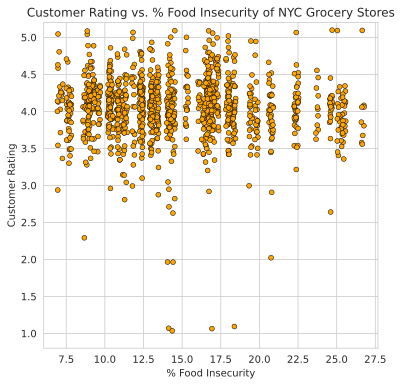

In [ ]:
#@title


Our next objective is to determine the distance people traveled to grocery stores by census block group (CBG) using [Safegraph data](https://docs.safegraph.com/docs/weekly-patterns). In particular, we would like to know for each CBG, the average distance they traveled to the listed grocery stores in March 2019, October 2019, March 2020, and October 2020. (We select March and October to avoid summer and holidays with more noise from tourists and festivity shopping). In this project, we will use the distances projected in the NAD83 plane (EPSG:2263).


## INPUT

### **`nyc_supermarkets.csv`**
[download](https://drive.google.com/file/d/1RmxHrY1UNVfAtU8Wut_oqz-G7nsU3Ss-/view?usp=sharing)

This CSV file contains a subset of the grocery stores that we collected through Google Places API. It is a subset because not every store has corresponding POI in the [Safegraph Places dataset](https://docs.safegraph.com/docs/core-places).

|place_id|latitude|longitude|name|vicinity|rating|user_ratings_total|community_district|percent_food_insecurity|safegraph_placekey|safegraph_name|
|--|--|--|--|--|--|--|--|--|--|--|
|...|...|...|...|...|...|...|...|...|...|...|

In this challenge, we are only interested in the **safegraph_placekey** column which matches the **placekey** column in the Weekly Pattern dataset.


This dataset is considered *small*, and will not be stored on HDFS (when we run our job).



### **`nyc_cbg_centroids.csv`**
[download](https://drive.google.com/file/d/196F50FfY1kHJItadHcU_kQCdViV6puHT/view?usp=sharing)

This CSV file contains the centroid location for each census block group (CBG). This information will be useful in computing the haversine distance between two CBGs. The dataset has the following columns:

|cbg_fips|latitude|longitude|
|--|--|--|
|...|...|...|

**cbg_fips** refers to the FIPS code of the CBGs used in Safegraph, it has the following format:

<img src="https://drive.google.com/uc?id=1io_iPuKOtq0KThPDfpvDAQEd79l6vZVs"></img>

The FIPS code for New York State is **036**. The five boros of New York would have the following FIPS prefix:

|Boro|FIPS Prefix|
|--|--|
|Manhattan|36061...|
|Bronx|36005...
|Brooklyn|36047...|
|Queens|36081...|
|Staten Island|36085...|

This dataset is considered *small*, and will not be stored on HDFS (when we run our job).

### **`weekly-patterns-nyc-2019-2020`**
The data is located under the bucket `gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*`.

This is the *big data* part of the challenge. It is stored on HDFS at the above location. It is a subset of the [Weekly Patterns](https://docs.safegraph.com/docs/weekly-patterns) dataset from Safegraph containing visit patterns for various locations in NYC in 2019 and 2020. We are going to use this data set to derive the traveled distances. Here are the columns of interests:

* **placekey**: can be used to crosscheck with the stores in `nyc_supermarkets.csv`
* **poi_cbg**: the CBG of the store (where people travel to)
* **visitor_home_cbgs**: the list of home CBGs where the visitors were traveling from (yes, we assume they went from home to stores).
* **date_range_end**, **date_range_start**: we use these two date to determine which month the **visitor_home_cbgs** should be used for (more on the pipeline below).


## OUTPUT
You are asked to produce the following output on HDFS in CSV format with the first row of partition 0 (or every partition) containing the column header. Each cell represents the average distance (in miles) that people travel from the corresponding CBG in the month specified in the column. An empty cell suggests that there were no data for that month.

|cbg_fips|2019-03|2019-10|2020-03|2020-10|
|--|--|--|--|--|
|360050147011||0.54|3.21|0.28|
|360050177013|0.22|0.42||0.17|
|360050177023|0.33|0.22|3.45||
|...|...|...|...|...|

The data must be **sorted by `cbg_fips`**.

You must at least run your code once and produce an output under `gs://bdma/shared/2023_spring/FC/EMPLID_LastName` (replacing `EMPLID` and `LastName` with yours).

## APPROACH

To minize the descrepancies, we provide the logic/steps needed to derive the output:

1. Use **`nyc_supermarkets.csv`** to filter the visits in the weekly patterns data
2. Only visit patterns with `date_range_start` or `date_range_end` overlaps with the 4 months of interests (Mar 2019, Oct 2019, Mar 2020, Oct 2020) will be considered, i.e. either the start or the end date falls within the period.
3. Use `visitor_home_cbgs` as the travel origins, and only consider CBG FIPS for NYC (must exist in **`nyc_cbg_centroids.csv`**).
4. Travel distances are the distances between each CBG in `visitor_home_cbgs` with `poi_cbg`. The distance must be computed in miles. To compute the distance between coordinates locally to NYC more accurately, please project them to the EPSG 2263 first.
5. The average should be computed from the total travel distances and the total number of visitors (similar to the way we compute the average in Lab 4).

## SUBMISSION
While you can test using Colab, your final submission must be a single `.py` file that runs on DataProc with the following command

```
!gcloud dataproc jobs submit pyspark --cluster bdma --files nyc_supermarkets.csv,nyc_cbg_centroids.csv \
--properties-file=props.conf BDM_FC_EMPLID_LastName.py -- OUTPUT_FOLDER_NAME
```

and the following configuration file (use `%%writefile props.conf`):
```
spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=YOUR_PROJECT_ID
spark.executor.instances='4'
spark.executor.cores='4'
```

**REMEMBER** to create your cluster with 4 workers instead of 2 (`--num-workers 4`).

Notes:
* `OUTPUT_FOLDER_NAME`: being specified by the user at run-time. You can access this variable through `sys.argv[1]` in your code. Your code must output data into this folder (e.g. through `saveAsTextFile`).
* As noted above, you need to at least successfully run your code once and output the data to `gs://bdma/shared/2023_spring/FC/EMPLID_LastName` (replacing `EMPLID` and `LastName` with yours).`
* `nyc_supermarkets.csv` and `nyc_cbg_centroids.csv` will be in the same folder with your code when we evaluate your assignment.

##**TIME LIMIT**: your code must not take more than 5 minutes to complete.

## DATA SAMPLING

We would like to take advantage of the interactivity of a notebook to develop our Spark's pipeline. Ideally, we would like to have both data sets available on Colab for developoment. However, the pattern data set is considerably large (10GB), and would be expensive (in term of computing resources) to upload and work with them from here. So our strategy is to *sample* the pattern data set to only 1% (~100MB). We will use the POI data set as is.

The simple code below can be used for sampling 1% of the pattern data. We make use of [RDD's sample() method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html#pyspark.RDD.sample) for this task. The first argument (`False`) is to specify that we would like to do a sample without replacement. Note that we separate the header and union it with the sampled data set to retained the header after sampling.

```python
from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    HDFS_INPUT = 'gs://bdma/data/weekly-patterns-nyc-2019-2020'
    header = sc.textFile(f'{HDFS_INPUT}/part-00000').first()
    sc.textFile(f'{HDFS_INPUT}/part-*') \
        .sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('gs://YOUR_BUCKET/weekly-patterns-nyc-2019-2020-sample')
```

## Environment Setup


In [ ]:
!pip install pyproj
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython

pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

from pyspark.sql import Window
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, lit, to_date, date_format, explode,  udf
from pyspark.sql.functions import from_json, sum, count

import pyproj
from pyproj import Proj, transform

### A. [TODO] Run the above script on our cluster
Please save the above code snippet into a Python file, then choose a method of your choice (e.g. GitHub, Upload, or `scp`) to transfer this script onto your storage on the cluster.

Assuming that you have named the script as `BDM_Final_Sample.py`, then once on the cluster, run the script with the following command:

```
!gcloud dataproc jobs submit pyspark --cluster YOUR_CLUSTER --properties-file=props.conf BDM_FC_Sample.py
```

After running the script, there should be a new folder created on your home folder on Cloud Storage bucket named `weekly-patterns-nyc-2019-2020-sample`. There should only be a file in that folder. That should be our sampled CSV file.


In [ ]:
!pip install google-cloud-dataproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.5/307.5 kB 14.0 MB/s eta 0:00:00


In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=6IbwauC85D0l8MDIleeriSNXJfcK5G&prompt=consent&access_type=offline&code_challenge=__d0yJou24e44NTGerADqV6DEZ1M7ioouryKsAZSRpA&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VNtD4tXjw2sfCgQQSjxEVdFcfuNO4KW6FkBt5M8Lty17a5Cx3IsU_INRseH1pmYtg

You are now logged in as [sumaiyauddin1995@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_I

In [ ]:
!gcloud projects list

PROJECT_ID             NAME              PROJECT_NUMBER
big-data-380022        big data          901723776519
rich-suprstate-380020  My First Project  72957410723


In [ ]:
!gcloud config set project big-data-380022
!gcloud config set compute/region us-west1
!gcloud config set compute/zone us-west1-a
!gcloud config set dataproc/region us-west1

Updated property [core/project].
Updated property [compute/region].
Updated property [compute/zone].
Updated property [dataproc/region].


In [ ]:
!gcloud dataproc clusters create bdma --enable-component-gateway --region us-west1 --zone us-west1-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 4 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 2.0-debian10 --project big-data-380022

Waiting on operation [projects/big-data-380022/regions/us-west1/operations/5a280cad-e1d2-33ba-afbb-bb09ea3bcf60].

Created [https://dataproc.googleapis.com/v1/projects/big-data-380022/regions/us-west1/clusters/bdma] Cluster placed in zone [us-west1-a].


In [ ]:
%%writefile props.conf
#!/usr/bin/python

spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=big-data-380022
spark.executor.instances='4'
spark.executor.cores='4'

Overwriting props.conf


In [ ]:
%%writefile BDM_Final_Sample.py
#!/usr/bin/python

from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    HDFS_INPUT = 'gs://bdma/data/weekly-patterns-nyc-2019-2020'
    header = sc.textFile(f'{HDFS_INPUT}/part-00000').first()
    sc.textFile(f'{HDFS_INPUT}/part-*') \
        .sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('gs://uddin-bdma/weekly-patterns-nyc-2019-2020-sample')

Overwriting BDM_Final_Sample.py


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdma --properties-file=props.conf BDM_Final_Sample.py

Job [32d4c324353d46dc8f1575da5b70b153] submitted.
Waiting for job output...
23/05/11 18:38:40 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/11 18:38:40 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/11 18:38:40 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/11 18:38:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/11 18:38:40 INFO org.sparkproject.jetty.util.log: Logging initialized @4580ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/11 18:38:40 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/11 18:38:40 INFO org.sparkproject.jetty.server.Server: Started @4727ms
23/05/11 18:38:40 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@481218da{HTTP/1.1, (http/1.1)}{0.0.0.0:43653}
23/05/11 18:38:41 INFO org.apache.hadoop.yarn.client.RMPro

### B. [TODO] Download data sets to the notebook
Download the file from Step A and upload to your Google Drive. Make sure to enable the share option of "Any with link" to the file, and copy its ID in the shared link. Run the below command to have the `weekly-patterns-nyc-2019-2020-sample.csv` file available to our notebook. Remember to replace ID with your file id. You can double check if the file is right by using the Files tab on the left.

In [ ]:
# Replace YOUR_FILE_ID below with your Google Drive File's ID
!gdown -q 1gUM8F5IEkg1sUBJJdPppmDOrGTUSbl4P -O weekly-patterns-nyc-2019-2020-sample.csv
!gdown -q 1T8s5XfHxNsS5GlW4UVk8LuSBAUClNGy0 -O nyc_supermarkets.csv
!gdown -q 1QTlIWUNd7PsOMbOkhFdIsQsr0NShkVpM -O nyc_cbg_centroids.csv

In [ ]:
!head weekly-patterns-nyc-2019-2020-sample.csv

"placekey","safegraph_place_id","parent_placekey","parent_safegraph_place_id","location_name","street_address","city","region","postal_code","iso_country_code","safegraph_brand_ids","brands","date_range_start","date_range_end","raw_visit_counts","raw_visitor_counts","visits_by_day","visits_by_each_hour","poi_cbg","visitor_home_cbgs","visitor_daytime_cbgs","visitor_country_of_origin","distance_from_home","median_dwell","bucketed_dwell_times","related_same_day_brand","related_same_week_brand","device_type"
zzw-22f@627-s8q-zzz,sg:7ca9090b6f974107893558f8063b76d6,zzy-225@627-s8q-zzz,sg:832e1a49583a478a8f0f1dd554f76d85,Love Thy Beast,109 E 42nd St,New York,NY,10017,US,,,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,1034,374,"[82,128,180,186,188,164,106]","[2,0,0,0,1,1,1,3,4,5,1,3,2,10,6,5,8,5,3,12,0,0,8,2,2,4,8,0,8,2,0,4,0,6,6,6,4,6,2,12,12,8,2,14,6,8,8,0,0,4,2,2,0,2,6,6,6,12,12,12,4,12,6,10,8,18,14,14,14,6,2,8,6,2,2,0,2,0,4,0,10,10,12,10,20,12,14,8,6,20,6,16,10,8,6,2,0,2,4,0,4,2,2,4,

In [ ]:
# Define the file path

weekly = "weekly-patterns-nyc-2019-2020-sample.csv"

# Read the CSV file as an RDD
weekly_rdd = spark.sparkContext.textFile(weekly)

def extractFeatures2(partId, rows):
    if partId == 0:
        next(rows)  # skipping the header
    reader = csv.reader(rows)
    for fields in reader:
        placekey = fields[0]
        poi_cbg = fields[18]
        visitor_home_cbgs = fields[19]
        date_range_start = fields[12]
        date_range_end = fields[13]
        yield (placekey, poi_cbg, visitor_home_cbgs, date_range_start, date_range_end)

weekly_rdd = weekly_rdd.mapPartitionsWithIndex(extractFeatures2)
weekly_df = weekly_rdd.toDF(["placekey", "poi_cbg", "visitor_home_cbgs", "date_range_start", "date_range_end"])
# Show the DataFrame
print(weekly_df.count())
weekly_df.show(5)

92648
+-------------------+------------+--------------------+--------------------+--------------------+
|           placekey|     poi_cbg|   visitor_home_cbgs|    date_range_start|      date_range_end|
+-------------------+------------+--------------------+--------------------+--------------------+
|zzw-22f@627-s8q-zzz|360610092001|{"360610092001":9...|2018-12-31T00:00:...|2019-01-07T00:00:...|
|zzw-223@627-s6m-7t9|360610273001|{"360610293005":4...|2018-12-31T00:00:...|2019-01-07T00:00:...|
|zzw-222@627-s7m-zfz|360810623001|{"360810601002":4...|2018-12-31T00:00:...|2019-01-07T00:00:...|
|22s-222@627-wgw-c3q|360470220002|{"360470476001":4...|2018-12-31T00:00:...|2019-01-07T00:00:...|
|22c-222@627-s4m-xyv|360610148024|{"360050236001":5...|2018-12-31T00:00:...|2019-01-07T00:00:...|
+-------------------+------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Read nyc_supermarkets.csv into a Pandas DataFrame and select only the safegraph_placekey column
df3 = pd.read_csv("nyc_supermarkets.csv", usecols=["safegraph_placekey"])

# Convert Pandas DataFrame to Spark DataFrame and rename the safegraph_placekey column to placekey
market_df = spark.createDataFrame(df3) \
                 .withColumnRenamed("safegraph_placekey", "placekey")

In [ ]:
# Join the two dataframes by placekey
joined_df = weekly_df.join(market_df, "placekey") \
                     .withColumn("date_range_start", to_date(col("date_range_start"))) \
                     .withColumn("date_range_end", to_date(col("date_range_end")))
joined_df.count()

914

In [ ]:
# Convert date_range_start and date_range_end columns to yyyy-MM format
joined_df = joined_df.withColumn("date_range_start", date_format(col("date_range_start"), "yyyy-MM")) \
                     .withColumn("date_range_end", date_format(col("date_range_end"), "yyyy-MM"))

# Print the count and show the first 5 rows
print(joined_df.count())
joined_df.show(5)

914
+-------------------+------------+--------------------+----------------+--------------+
|           placekey|     poi_cbg|   visitor_home_cbgs|date_range_start|date_range_end|
+-------------------+------------+--------------------+----------------+--------------+
|23p-222@627-wd8-xnq|360470386002|{"360470382003":1...|         2019-04|       2019-04|
|23p-222@627-wd8-xnq|360470386002|{"360470382003":9...|         2019-09|       2019-09|
|238-222@627-s7s-skf|360810401002|{"360810399001":6...|         2019-04|       2019-05|
|zzw-222@627-s9d-9vf|360810365002|  {"360810379003":4}|         2019-06|       2019-06|
|22d-222@627-s6d-6x5|360610245003|{"360610241001":4...|         2019-08|       2019-08|
+-------------------+------------+--------------------+----------------+--------------+
only showing top 5 rows



In [ ]:
# Create a list of the four months of interest
months_of_interest = [3, 10]


# Filter the DataFrame based on the conditions
joined_df = joined_df.filter((month("date_range_start").isin(months_of_interest)) |
                             (month("date_range_end").isin(months_of_interest)))

joined_df.show(5)

+-------------------+------------+--------------------+----------------+--------------+
|           placekey|     poi_cbg|   visitor_home_cbgs|date_range_start|date_range_end|
+-------------------+------------+--------------------+----------------+--------------+
|22k-222@627-s8r-2hq|360610088003|{"360810288004":4...|         2019-03|       2019-04|
|zzy-224@627-wc9-2tv|360470001004|  {"360470492001":4}|         2019-10|       2019-10|
|223-222@627-rw6-zfz|360050386008|{"360050386006":6...|         2020-02|       2020-03|
|227-222@627-s5x-fvf|360610309002|{"360610309002":6...|         2020-03|       2020-03|
|224-222@627-rwx-sqz|360050072003|{"360050016001":4...|         2019-03|       2019-03|
+-------------------+------------+--------------------+----------------+--------------+
only showing top 5 rows



In [ ]:
joined_df = joined_df.withColumn("date",when(month("date_range_start").isin(months_of_interest),col("date_range_start")).otherwise(col("date_range_end")))\
                      .select('placekey','poi_cbg','visitor_home_cbgs','date')

In [ ]:
# Read nyc_cbg_centroids.csv into a Pandas DataFrame
df3 = pd.read_csv("nyc_cbg_centroids.csv")

# Convert Pandas DataFrame to Spark RDD
cbg_df = spark.createDataFrame(df3)

In [ ]:
# Define the schema for the visitor_home_cbgs column
cbg_schema = "map<string,int>"

# Convert the visitor_home_cbgs column from string to map
joined_df2 = joined_df.withColumn("visitor_home_cbgs", from_json(col("visitor_home_cbgs"), cbg_schema)) \
                       .filter(col("visitor_home_cbgs").isNotNull()) \
                       .selectExpr("*", "explode(visitor_home_cbgs) as (visitor_home_cbg , visitors)") \
                       .drop("visitor_home_cbgs")
print(joined_df2.count())
joined_df2.show(5)

1856
+-------------------+------------+-------+----------------+--------+
|           placekey|     poi_cbg|   date|visitor_home_cbg|visitors|
+-------------------+------------+-------+----------------+--------+
|23m-223@627-wgv-435|360470106002|2020-03|    360470106002|       4|
|23m-223@627-wgv-435|360470106002|2020-03|    360470106002|       4|
|zzw-223@627-rwf-wc5|360050462011|2019-10|    360050462016|       6|
|zzw-223@627-rwf-wc5|360050462011|2019-10|    360810096002|       6|
|zzw-223@627-rwf-wc5|360050462011|2019-10|    360050302005|       5|
+-------------------+------------+-------+----------------+--------+
only showing top 5 rows



In [ ]:
joined_df3 = joined_df2.join(cbg_df,joined_df2.poi_cbg == cbg_df.cbg_fips,'inner') \
                 .drop('cbg_fips') \
                 .withColumnRenamed('latitude', 'to_lat') \
                 .withColumnRenamed('longitude', 'to_lon') \
                 .join(cbg_df,joined_df2.visitor_home_cbg==cbg_df.cbg_fips) \
                 .drop('cbg_fips') \
                 .withColumnRenamed('latitude', 'from_lat') \
                 .withColumnRenamed('longitude', 'from_lon') \
                 .withColumnRenamed('visitor_home_cbg', 'cbg_fips') \
                 .drop('placekey')


joined_df3.show(5)

+------------+-------+------------+--------+------------------+------------------+-----------------+------------------+
|     poi_cbg|   date|    cbg_fips|visitors|            to_lat|            to_lon|         from_lat|          from_lon|
+------------+-------+------------+--------+------------------+------------------+-----------------+------------------+
|360470226001|2019-03|360470222003|       4|40.641450784355854|-73.98543323984713|40.63917310846114| -73.9937407999223|
|360470226001|2019-03|360470476003|       4|40.641450784355854|-73.98543323984713|40.63197634288336|-73.98253563164538|
|360470226001|2019-03|360470492002|       4|40.641450784355854|-73.98543323984713|  40.640748941628|-73.97003283571912|
|360470226001|2019-03|360470236003|       4|40.641450784355854|-73.98543323984713|40.63286521014451|-73.99079319811214|
|360470226001|2019-03|360470084001|       4|40.641450784355854|-73.98543323984713|40.65419711994797|-74.00270951454537|
+------------+-------+------------+-----

In [ ]:

import pyproj
proj  = pyproj.Proj("+init=EPSG:2263")

# Define the UDF to convert coordinates to EPSG 2263
def convert_to_2263(lat, lon):
    x, y = proj(lon, lat)
    return x, y

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# Convert the coordinates to EPSG 2263
cbg_df2 = joined_df3.withColumn('poi_x', cbg_lon_udf(col('to_lat'), col('to_lon'))) \
                    .withColumn('poi_y', cbg_lat_udf(col('to_lat'), col('to_lon'))) \
                    .withColumn('cbg_x', cbg_lon_udf(col('from_lat'), col('from_lon'))) \
                    .withColumn('cbg_y', cbg_lat_udf(col('from_lat'), col('from_lon'))) \
                    .drop('from_lat', 'from_lon','to_lat','to_lon')

print(cbg_df2.count())
cbg_df2.show(5)

1672
+------------+-------+------------+--------+-----------------+------------------+-----------------+------------------+
|     poi_cbg|   date|    cbg_fips|visitors|            poi_x|             poi_y|            cbg_x|             cbg_y|
+------------+-------+------------+--------+-----------------+------------------+-----------------+------------------+
|360470226001|2019-03|360470222003|       4|988292.6305046651|172974.53101696563|985987.1396743141| 172144.4377912981|
|360470226001|2019-03|360470476003|       4|988292.6305046651|172974.53101696563|989097.4754887323|169522.88324331626|
|360470226001|2019-03|360470492002|       4|988292.6305046651|172974.53101696563|  992566.70485539|172719.91708654797|
|360470226001|2019-03|360470236003|       4|988292.6305046651|172974.53101696563|986805.4403892617|169846.37250727712|
|360470226001|2019-03|360470084001|       4|988292.6305046651|172974.53101696563|983498.1874003495|177618.04648086097|
+------------+-------+------------+--------

In [ ]:
joined_df3 = cbg_df2.withColumn("Distance",F.sqrt(F.pow(col('poi_y')-col('cbg_y'),2)+F.pow(col('poi_x')-col('cbg_x'),2))) \
        .drop("poi_cbg","poi_x","poi_y","cbg_x","cbg_y")

In [ ]:
print(joined_df3.count())
joined_df3.show(5)

1672
+-------+------------+--------+------------------+
|   date|    cbg_fips|visitors|          Distance|
+-------+------------+--------+------------------+
|2019-03|360470542003|       4|12026.768866183134|
|2019-03|360470232001|       4|2661.1856355265986|
|2019-03|360470374012|       4| 19816.86873797809|
|2019-03|360850189023|       4|43260.569189499845|
|2019-03|360470084001|       4| 6674.497774660957|
+-------+------------+--------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F

final_df = joined_df3.groupBy("cbg_fips") \
                            .pivot("date") \
                            .agg(F.sum(F.expr("visitors * distance")) / F.sum("visitors"))

In [ ]:
output = final_df.select('cbg_fips',F.round(F.col('2019-03'),2).cast("string").alias('2019-03'),
                F.round(F.col('2019-10'),2).cast("string").alias('2019-10'),
                F.round(F.col('2020-03'),2).cast('string').alias('2020-03'),
                F.round(F.col('2020-10'),2).cast('string').alias('2020-10')) \
        .fillna(value='') \
        .sort(F.col('cbg_fips'))

In [ ]:
# output.show(10)

In [ ]:
# from pyspark.sql.functions import sum, count

# avg_distance_df = joined_df6.groupBy('cbg_fips') \
#                            .agg(sum('distance').alias('total_distance'),
#                                 sum('visitors').alias('total_visitors')) \
#                            .withColumn('avg_distance', col('total_distance') / col('total_visitors')) \
#                            .select('cbg_fips', 'avg_distance')
# avg_distance_df.show(5)

In [ ]:
%%writefile props.conf
#!/usr/bin/python

spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=big-data-380022
spark.executor.instances='4'
spark.executor.cores='4'

Overwriting props.conf


In [ ]:
%%writefile BDM_FC_24373710_Uddin.py
#!/usr/bin/python

import csv
import json
import numpy as np
import pandas as pd
import IPython

from pyspark.sql import Window
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, lit, to_date, date_format, explode,  udf
from pyspark.sql.functions import from_json, sum, count
import sys
import pyproj
from pyproj import Proj, transform
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

weekly = "gs://bdma/data/weekly-patterns-nyc-2019-2020/part-*"

# Read the CSV file as an RDD
weekly_rdd = spark.sparkContext.textFile(weekly)

def extractFeatures2(partId, rows):
    if partId == 0:
        next(rows)  # skipping the header
    reader = csv.reader(rows)
    for fields in reader:
        placekey = fields[0]
        poi_cbg = fields[18]
        visitor_home_cbgs = fields[19]
        date_range_start = fields[12]
        date_range_end = fields[13]
        yield (placekey, poi_cbg, visitor_home_cbgs, date_range_start, date_range_end)

weekly_rdd = weekly_rdd.mapPartitionsWithIndex(extractFeatures2)
weekly_df = weekly_rdd.toDF(["placekey", "poi_cbg", "visitor_home_cbgs", "date_range_start", "date_range_end"])

# Read nyc_supermarkets.csv into a Pandas DataFrame and select only the safegraph_placekey column
df3 = pd.read_csv("nyc_supermarkets.csv", usecols=["safegraph_placekey"])

# Convert Pandas DataFrame to Spark DataFrame and rename the safegraph_placekey column to placekey
market_df = spark.createDataFrame(df3) \
                 .withColumnRenamed("safegraph_placekey", "placekey")


# Join the two dataframes by placekey
joined_df = weekly_df.join(market_df, "placekey") \
                     .withColumn("date_range_start", to_date(col("date_range_start"))) \
                     .withColumn("date_range_end", to_date(col("date_range_end")))


joined_df = joined_df.withColumn("date_range_start", date_format(col("date_range_start"), "yyyy-MM")) \
                     .withColumn("date_range_end", date_format(col("date_range_end"), "yyyy-MM"))



months_of_interest = [3, 10]
joined_df = joined_df.filter((month("date_range_start").isin(months_of_interest)) |
                             (month("date_range_end").isin(months_of_interest)))


joined_df = joined_df.withColumn("date",when(month("date_range_start").isin(months_of_interest),col("date_range_start")).otherwise(col("date_range_end")))\
                      .select('placekey','poi_cbg','visitor_home_cbgs','date')



df3 = pd.read_csv("nyc_cbg_centroids.csv")

# Convert Pandas DataFrame to Spark RDD
cbg_df = spark.createDataFrame(df3)

# Define the schema for the visitor_home_cbgs column
cbg_schema = "map<string,int>"

# Convert the visitor_home_cbgs column from string to map
joined_df2 = joined_df.withColumn("visitor_home_cbgs", from_json(col("visitor_home_cbgs"), cbg_schema)) \
                       .filter(col("visitor_home_cbgs").isNotNull()) \
                       .selectExpr("*", "explode(visitor_home_cbgs) as (visitor_home_cbg , visitors)") \
                       .drop("visitor_home_cbgs")


joined_df3 = joined_df2.join(cbg_df,joined_df2.poi_cbg == cbg_df.cbg_fips,'inner') \
                 .drop('cbg_fips') \
                 .withColumnRenamed('latitude', 'to_lat') \
                 .withColumnRenamed('longitude', 'to_lon') \
                 .join(cbg_df,joined_df2.visitor_home_cbg==cbg_df.cbg_fips) \
                 .drop('cbg_fips') \
                 .withColumnRenamed('latitude', 'from_lat') \
                 .withColumnRenamed('longitude', 'from_lon') \
                 .withColumnRenamed('visitor_home_cbg', 'cbg_fips') \
                 .drop('placekey')

proj  = pyproj.Proj("+init=EPSG:2263")

# Define the UDF to convert coordinates to EPSG 2263
def convert_to_2263(lat, lon):
    x, y = proj(lon, lat)
    return x, y

cbg_lat_udf = udf(lambda lat, lon: convert_to_2263(lat, lon)[1]/5280, DoubleType())
cbg_lon_udf = udf(lambda lat, lon: convert_to_2263(lat, lon)[0]/5280, DoubleType())

# Convert the coordinates to EPSG 2263
cbg_df2 = joined_df3.withColumn('poi_x', cbg_lon_udf(col('to_lat'), col('to_lon'))) \
                    .withColumn('poi_y', cbg_lat_udf(col('to_lat'), col('to_lon'))) \
                    .withColumn('cbg_x', cbg_lon_udf(col('from_lat'), col('from_lon'))) \
                    .withColumn('cbg_y', cbg_lat_udf(col('from_lat'), col('from_lon'))) \
                    .drop('from_lat', 'from_lon','to_lat','to_lon')



joined_df3 = cbg_df2.withColumn("Distance",F.sqrt(F.pow(col('poi_y')-col('cbg_y'),2)+F.pow(col('poi_x')-col('cbg_x'),2))) \
        .drop("poi_cbg","poi_x","poi_y","cbg_x","cbg_y")


final_df = joined_df3.groupBy("cbg_fips") \
                            .pivot("date") \
                            .agg(F.sum(F.expr("visitors * distance")) / F.sum("visitors"))


output = final_df.select('cbg_fips',F.round(F.col('2019-03'),2).cast("string").alias('2019-03'),
                F.round(F.col('2019-10'),2).cast("string").alias('2019-10'),
                F.round(F.col('2020-03'),2).cast('string').alias('2020-03'),
                F.round(F.col('2020-10'),2).cast('string').alias('2020-10')) \
        .fillna(value='') \
        .sort(F.col('cbg_fips'))



output_file_location = sys.argv[1]
output.write.csv(output_file_location,header=True)


Overwriting BDM_FC_24373710_Uddin.py


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdma --files nyc_supermarkets.csv,nyc_cbg_centroids.csv \
--properties-file=props.conf BDM_FC_24373710_Uddin.py -- gs://bdma/shared/2023_spring/FC/24373710_Uddin

Job [0ec7f1b62fe8469c941f5335deb48338] submitted.
Waiting for job output...
23/05/18 03:42:55 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/18 03:42:55 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/18 03:42:56 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/18 03:42:56 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/18 03:42:56 INFO org.sparkproject.jetty.util.log: Logging initialized @5730ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/18 03:42:56 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/18 03:42:56 INFO org.sparkproject.jetty.server.Server: Started @5886ms
23/05/18 03:42:56 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@35506968{HTTP/1.1, (http/1.1)}{0.0.0.0:40593}
23/05/18 03:42:57 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
!gsutil -u big-data-380022 cat gs://bdma/shared/2023_spring/FC/24373710_Uddin/part*

Streaming output truncated to the last 5000 lines.
360470082002,1.5,0.96,1.13,2.12
360470082003,1.41,0.15,0.33,3.67
360470084001,2.38,3.46,0.96,0.95
360470084002,3.7,3.6,1.12,2.93
360470084003,2.22,0.42,3.94,4.04
360470085001,2.39,1.26,2.46,1.52
360470085002,0.8,1.17,2.16,3.03
360470085003,2.29,0.95,3.21,1.63
360470086001,0.27,0.27,1.03,0.68
360470088001,4.32,0.92,1.55,4.74
360470088002,0.56,0.82,1.02,1.88
360470090001,2.95,2.35,1.83,2.12
360470090002,1.04,0.67,2.94,7.09
360470092001,2.07,2.71,1.02,0.74
360470092002,3.07,2.13,1.26,1.1
360470092003,0.51,1.51,0.34,5.03
360470094001,1.92,1.74,1.52,7.04
360470094002,2.56,0.79,1.04,2.21
360470094003,0.49,1.46,0.9,0.96
cbg_fips,2019-03,2019-10,2020-03,2020-10
360470096001,1.9,1.55,3.03,1.31
360470096002,1.17,0.98,0.96,0.54
360470096003,0.16,0.45,0.27,0.66
360470096004,2.06,1.74,0.66,0.99
360470098001,0.91,0.39,1.61,6.21
360470098002,0.47,2.21,3.54,3.27
360470098003,0.36,2.32,2.95,0.83
360470098004,1.1,0.28,1.36,1.84
360470100001,1.13,0.77,2.

In [ ]:
# !gsutil -u big-data-380022 rm -r gs://bdma/shared/2023_spring/FC/24373710_Uddin

# IMPORTANT: DELETE YOUR CLUSTER AFTER DONE

In [ ]:
!gcloud dataproc clusters delete bdma -q
!gcloud dataproc clusters list

Waiting on operation [projects/big-data-380022/regions/us-west1/operations/a2622b9f-3051-3660-9299-3092ccf197ce].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-380022/regions/us-west1/clusters/bdma].
Listed 0 items.
